<h1 style='color:purple' align='center'>Predicting Home Prices in Banglore</h1>

Dataset is downloaded from here: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

In [62]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)

<h2 style='color:blue'>Data Load: Load banglore home prices into a dataframe</h2>

In [63]:
df1 = pd.read_csv("C:/Users/debaj/Downloads/Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [64]:
df1.shape

(13320, 9)

In [65]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [66]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area',
       'Carpet  Area'], dtype=object)

In [67]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

**Drop features that are not required to build our model**

In [68]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

<h2 style='color:blue'>Data Cleaning: Handle NA values</h2>

In [69]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [70]:
df2.shape

(13320, 5)

In [71]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [72]:
df3.shape

(13246, 5)

<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [73]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\debaj\AppData\Local\Temp/ipykernel_12156/2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

**Explore total_sqft feature**

In [74]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [75]:
2+3

5

In [76]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [77]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [78]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


**For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850**

In [79]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

In [80]:
(2100+2850)/2

2475.0

<h2 style="color:blue">Feature Engineering</h2>

**Add new feature called price per square feet**

In [81]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [82]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [83]:
df5.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [84]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

Whitefield                   533
Sarjapur  Road               392
Electronic City              304
Kanakpura Road               264
Thanisandra                  235
                            ... 
Rajanna Layout                 1
Subramanyanagar                1
Lakshmipura Vidyaanyapura      1
Malur Hosur Road               1
Abshot Layout                  1
Name: location, Length: 1287, dtype: int64

In [85]:
location_stats.values.sum()

13200

In [86]:
len(location_stats[location_stats>10])

240

In [87]:
len(location_stats)

1287

In [88]:
len(location_stats[location_stats<=10])

1047

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 50 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [89]:
location_stats_less_than_50 = location_stats[location_stats<=50]
location_stats_less_than_50

Ramagondanahalli             50
Hegde Nagar                  49
Bhoganhalli                  49
Gottigere                    48
Mysore Road                  48
                             ..
Rajanna Layout                1
Subramanyanagar               1
Lakshmipura Vidyaanyapura     1
Malur Hosur Road              1
Abshot Layout                 1
Name: location, Length: 1234, dtype: int64

In [90]:
len(df5.location.unique())

1287

In [91]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_50 else x)
len(df5.location.unique())

54

In [92]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,other,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,other,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,other,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


<h2 style="color:blue">Outlier Removal Using Business Logic</h2>

**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [93]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,other,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,other,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [94]:
df5.shape

(13200, 7)

In [95]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

<h2 style='color:blue'>Outlier Removal Using Standard Deviation and Mean</h2>

In [96]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [97]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10771, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

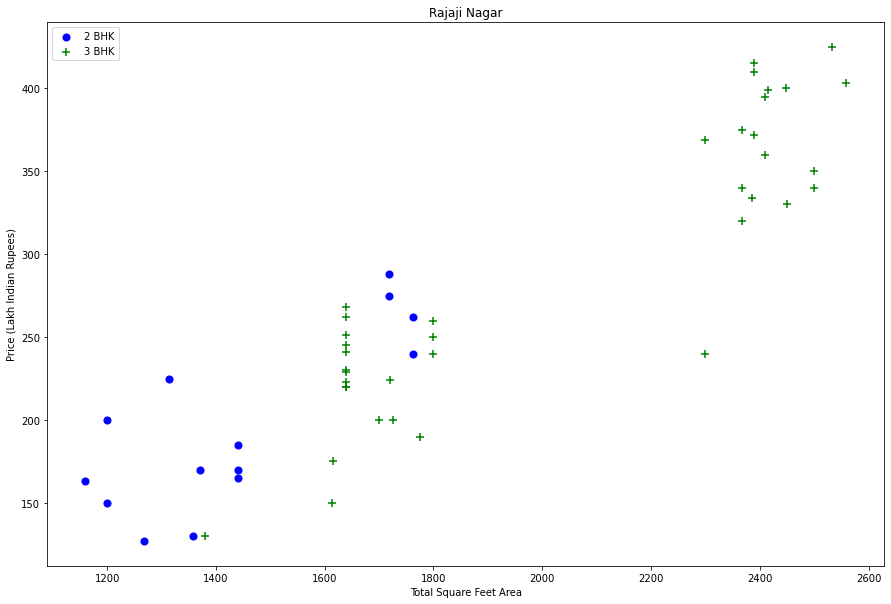

In [98]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

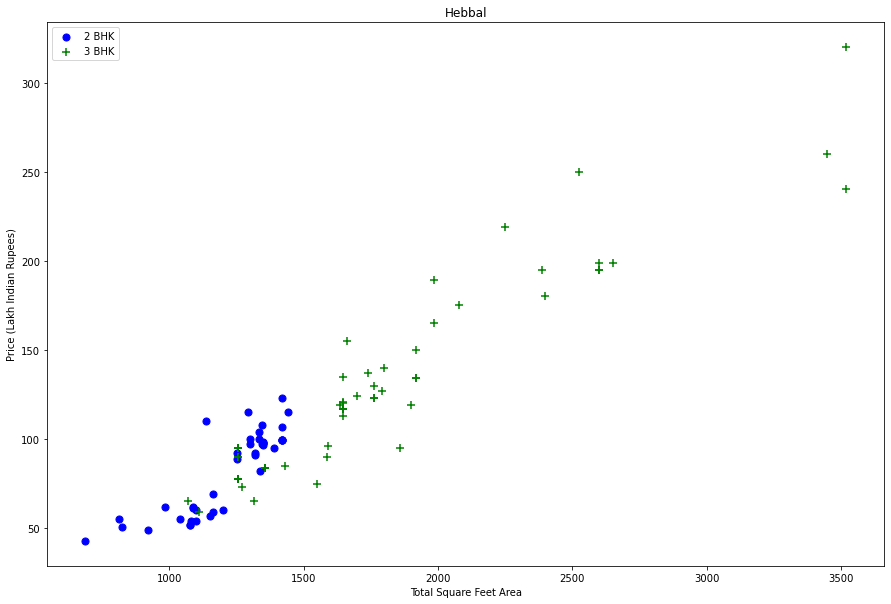

In [99]:
plot_scatter_chart(df7,"Hebbal")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [100]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(6541, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

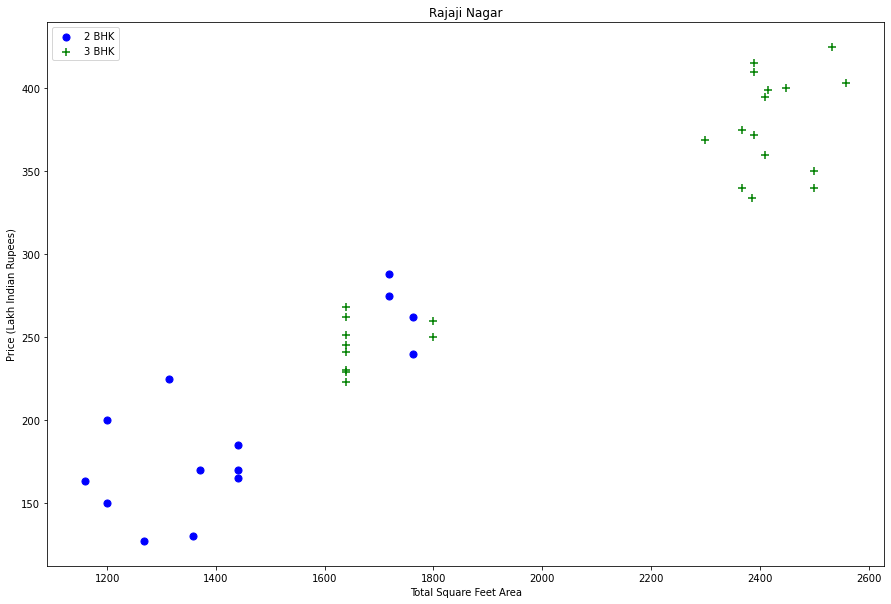

In [101]:
plot_scatter_chart(df8,"Rajaji Nagar")

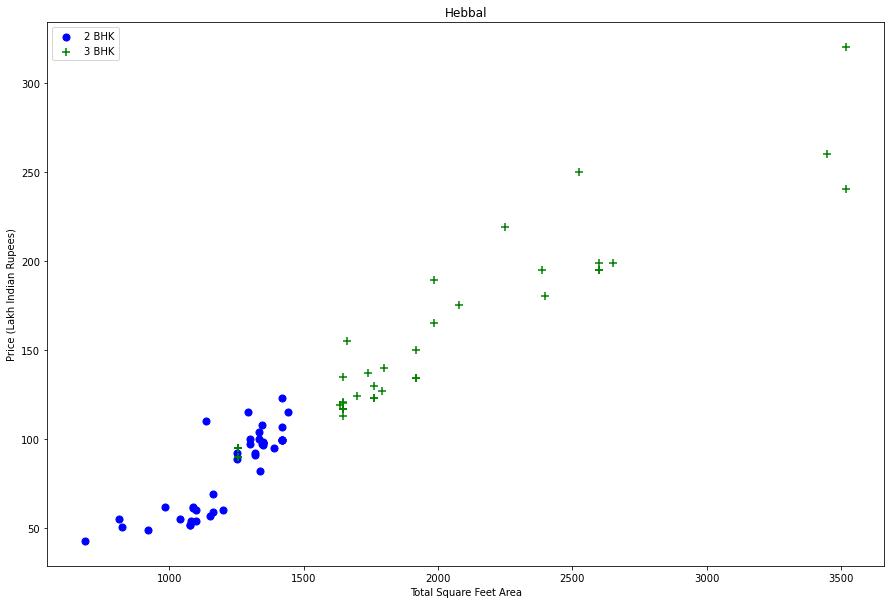

In [102]:
plot_scatter_chart(df8,"Hebbal")

**Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function**

<h3 style='color:green'>Before and after outlier removal: Rajaji Nagar</h3>

<img src="rajaji_nagar_outliers.png"></img>

<h3 style='color:green'>Before and after outlier removal: Hebbal</h3>

<img src="hebbal_outliers.png"></img>

Text(0, 0.5, 'Count')

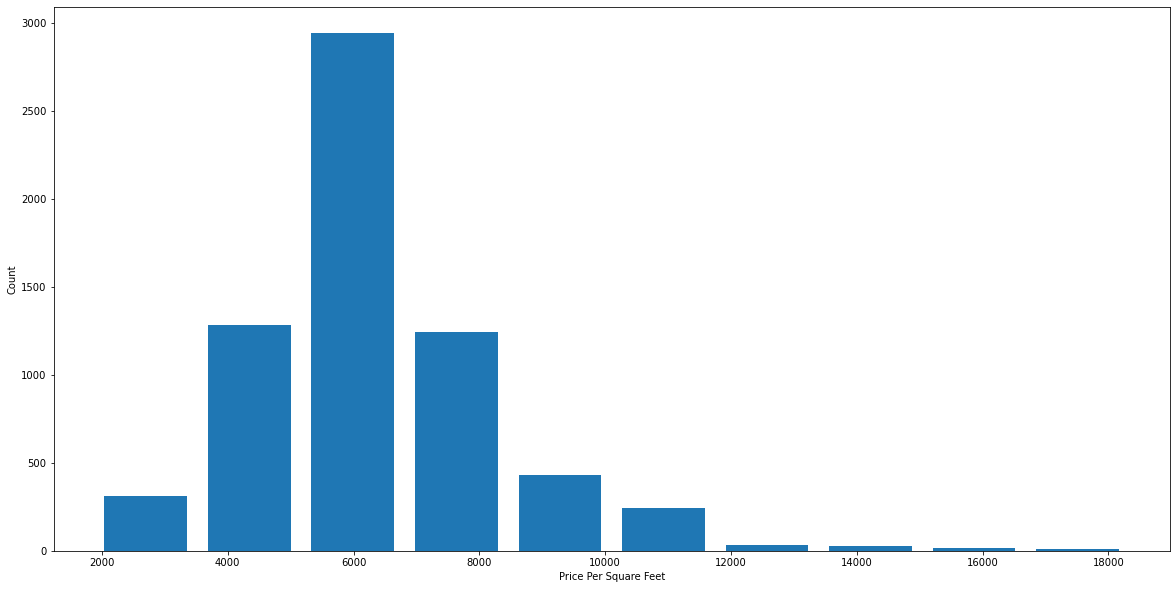

In [103]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [104]:
df8.bath.unique()

array([ 2.,  3.,  4.,  1.,  5.,  6.,  8.,  9.,  7., 16., 12., 13.])

Text(0, 0.5, 'Count')

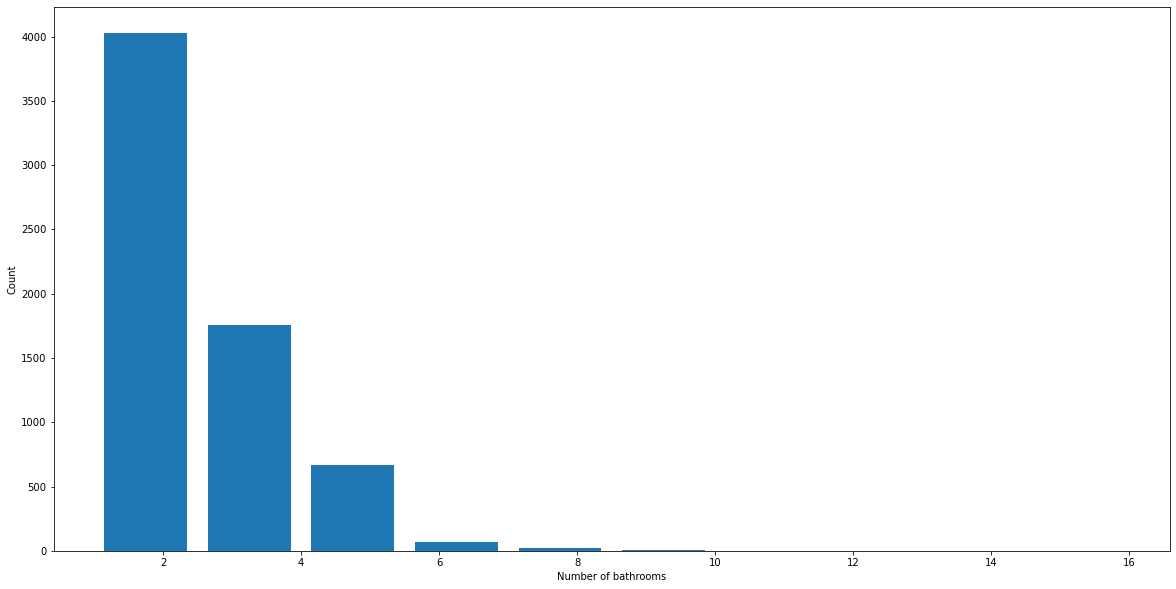

In [105]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [106]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
6479,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
8366,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9262,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [107]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
3821,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
6023,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689
9875,other,4 Bedroom,7000.0,8.0,450.0,4,6428.571429


**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [108]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(6473, 7)

In [109]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,7th Phase JP Nagar,2 BHK,1080.0,2.0,72.0,2,6666.666667
1,7th Phase JP Nagar,2 BHK,1270.0,2.0,93.0,2,7322.834646


In [110]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,7th Phase JP Nagar,1080.0,2.0,72.0,2
1,7th Phase JP Nagar,1270.0,2.0,93.0,2
2,7th Phase JP Nagar,1420.0,2.0,100.0,3


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [111]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,7th Phase JP Nagar,8th Phase JP Nagar,Akshaya Nagar,Banashankari,Bannerghatta Road,Begur Road,Bellandur,Bisuvanahalli,Budigere,Chandapura,...,Sarjapur Road,TC Palaya,Thanisandra,Thigalarapalya,Uttarahalli,Varthur,Whitefield,Yelahanka,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
df11 = pd.concat([df10,dummies],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,7th Phase JP Nagar,8th Phase JP Nagar,Akshaya Nagar,Banashankari,Bannerghatta Road,...,Sarjapur Road,TC Palaya,Thanisandra,Thigalarapalya,Uttarahalli,Varthur,Whitefield,Yelahanka,Yeshwanthpur,other
0,7th Phase JP Nagar,1080.0,2.0,72.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7th Phase JP Nagar,1270.0,2.0,93.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7th Phase JP Nagar,1420.0,2.0,100.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7th Phase JP Nagar,1850.0,3.0,150.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7th Phase JP Nagar,1245.0,2.0,94.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,7th Phase JP Nagar,8th Phase JP Nagar,Akshaya Nagar,Banashankari,Bannerghatta Road,...,Sarjapur,Sarjapur Road,TC Palaya,Thanisandra,Thigalarapalya,Uttarahalli,Varthur,Whitefield,Yelahanka,Yeshwanthpur
0,7th Phase JP Nagar,1080.0,2.0,72.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7th Phase JP Nagar,1270.0,2.0,93.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7th Phase JP Nagar,1420.0,2.0,100.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7th Phase JP Nagar,1850.0,3.0,150.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7th Phase JP Nagar,1245.0,2.0,94.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
df12 = df11.drop('location',axis='columns')
df12.head(700)

,total_sqft,bath,price,bhk,7th Phase JP Nagar,8th Phase JP Nagar,Akshaya Nagar,Banashankari,Bannerghatta Road,Begur Road,...,Sarjapur,Sarjapur Road,TC Palaya,Thanisandra,Thigalarapalya,Uttarahalli,Varthur,Whitefield,Yelahanka,Yeshwanthpur
0,1080.0,2.0,72.00,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1270.0,2.0,93.00,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1420.0,2.0,100.00,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1850.0,3.0,150.00,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1245.0,2.0,94.00,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,1128.0,2.0,65.45,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
922,890.0,2.0,40.00,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
927,1360.0,2.0,58.00,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
930,630.0,1.0,33.70,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0












<h2 style='color:blue'>Build a Model Now...</h2>

In [115]:
df12.shape

(6473, 57)

In [116]:
X = df12.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,7th Phase JP Nagar,8th Phase JP Nagar,Akshaya Nagar,Banashankari,Bannerghatta Road,Begur Road,Bellandur,...,Sarjapur,Sarjapur Road,TC Palaya,Thanisandra,Thigalarapalya,Uttarahalli,Varthur,Whitefield,Yelahanka,Yeshwanthpur
0,1080.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1270.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1420.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
X.shape

(6473, 56)

In [118]:
y = df12.price
y.head(3)

0     72.0
1     93.0
2    100.0
Name: price, dtype: float64

In [119]:
len(y)

6473

In [120]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [121]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8826222210764626

In [122]:
X_t=X_test.values
y_t=y_test.values

In [123]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)
i=2
xx=model.predict([X_t[i]])
print(xx)
print(X_t[i])
print(y_t[i])

[157.82218297]
[2.247e+03 3.000e+00 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00]
145.0


<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [124]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.87622731, 0.89062957, 0.86616483, 0.88300135, 0.8815157 ])

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [125]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.879508,{'normalize': False}
1,lasso,0.815090,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.852916,"{'criterion': 'mse', 'splitter': 'best'}"


In [126]:
import base64
from IPython.display import HTML
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe


# create a link to download the dataframe
create_download_link(df12)

In [128]:
from sklearn.metrics import mean_squared_error
ans=model.predict(X_t)
mean_squared_error(y_t,ans)


657.3332382900069

**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**